# MapReduce
`大数据: 收集到的数据已经远远超出了我们的处理能力。`

`MapReduce: 映射化简, 分布式的计算框架，可以将单个计算作业分配给多台计算机执行`

## MapRedece 原理

> MapRedece 工作原理

* 主节点控制 MapReduce 的作业流程
* MapReduce 的作业可以分成map任务和reduce任务
* map 任务之间不做数据交流，reduce 任务也一样
* 在 map 和 reduce 阶段中间，有一个 sort 和 combine 阶段
* 数据被重复存放在不同的机器上，以防止某个机器失效
* mapper 和 reducer 传输的数据形式为 key/value对

![cff](./原理.png)
![](../img/激活函数.png)
> MapRedece 特点

```
优点: 使程序以并行的方式执行，可在短时间内完成大量工作。
缺点: 算法必须经过重写，需要对系统工程有一定的理解。
适用数据类型: 数值型和标称型数据。
```

### Hadoop 流(Python 调用)
> 理论简介

例如: Hadoop流可以像Linux命令一样执行

```Shell
cat inputFile.txt | python mapper.py | sort | python reducer.py > outputFile.txt
```

类似的Hadoop流就可以在多台机器上分布式执行，用户可以通过Linux命令来测试Python语言编写的MapReduce脚本。

> 脚本测试

```
# 测试 Mapper
# Linux
cat data/inputFile.txt | python mrMeanMapper.py

# 测试 Reducer
# Linux
cat data/inputFile.txt | python mrMeanMapper.py | python mrMeanReducer.py
```

## MapReduce 机器学习

映射化简和数据并行对于大规模机器学习问题而言是非常重要的概念。之前提到，如果我们用批量梯度下降算法来求解大规模数据集的最优解，我们需要对整个训练集进行循环，计算偏导数和代价，再求和，计算代价非常大。如果我们能够将我们的数据集分配给不多台计算机，让每一台计算机处理数据集的一个子集，然后我们将计所的结果汇总在求和。这样的方法叫做映射简化。

具体而言，如果任何学习算法能够表达为，对训练集的函数的求和，那么便能将这个任务分配给多台计算机（或者同一台计算机的不同CPU 核心），以达到加速处理的目的。

1. 简单贝叶斯：它属于为数不多的可以很自然的使用MapReduce的算法。通过统计在某个类别下某特征的概率。
2. k-近邻算法：高维数据下（如文本、图像和视频）流行的近邻查找方法是局部敏感哈希算法。
3. 支持向量机(SVM)：使用随机梯度下降算法求解，如Pegasos算法。
4. 奇异值分解：Lanczos算法是一个有效的求解近似特征值的算法。
5. k-均值聚类：canopy算法初始化k个簇，然后再运行K-均值求解结果。
1. 批量梯度下降: 例如，我们有400个训练实例，我们可以将批量梯度下降的求和任务分配给4台计算机进行处理
![](./MapReduce_BGD.png)

## 脚本分析

分布式计算均值和方差

In [8]:
#!/usr/bin/python
# coding:utf-8

'''
Created on 2017-04-07
Update  on 2017-11-17
Author: Peter/ApacheCN-xy/片刻
GitHub: https://github.com/apachecn/AiLearning
'''

from mrjob.job import MRJob
from mrjob.step import MRStep


class MRmean(MRJob):
    def __init__(self, *args, **kwargs):  # 对数据初始化
        super().__init__(*args, **kwargs)
        self.inCount = 0
        self.inSum = 0
        self.inSqSum = 0

    # 接受输入数据流
    def map(self, key, val):  # 以key/value的形式传递
        if False:
            yield
        inVal = float(val)
        self.inCount += 1
        self.inSum += inVal
        self.inSqSum += inVal*inVal

    # 所有输入到达后开始处理
    def map_final(self):  # 计算数据的平均值，平方的均值，并返回
        if self.inCount == 0:
            return
        mean = self.inSum/self.inCount
        meanSq = self.inSqSum/self.inCount
        # 所有的mapper都以 1做为key(即所有的mapper最后在同一个reducer里处理)
        yield (1, [self.inCount, mean, meanSq])

    def reduce(self, key, packedValues):
        cumN, cumVal, cumSumSq = 0.0, 0.0, 0.0
        for valArr in packedValues:  # 从输入流中获取值
            nj = float(valArr[0])
            cumN += nj
            cumVal += nj*float(valArr[1])
            cumSumSq += nj*float(valArr[2])
        mean = cumVal/cumN
        var = (cumSumSq - 2*mean*cumVal + cumN*mean*mean)/cumN
        yield (mean, var)  # 发出平均值和方差
        # 如果reduce后还要执行另一个mapper, 那么仍然需要一个key

    def steps(self):
        """
        step方法定义执行的步骤。
        执行顺序不必完全遵循map-reduce模式。
        例如：
            1. map-reduce-reduce-reduce
            2. map-reduce-map-reduce-map-reduce
        在step方法里，需要为mrjob指定mapper和reducer的名称。如果没有，它将默认调用mapper和reducer方法。

        在mapper 和 mapper_final中还可以共享状态，mapper 或 mapper_final 不能与 reducer之间共享状态。
        """
        return [MRStep(mapper=self.map, mapper_final=self.map_final, reducer=self.reduce)]

测试mapper方法:
```shell
python mrMean.py --mapper < data/inputFile.txt
```
运行整个程序:
```
python mrMean.py data/inputFile.txt
```

### 项目案例：分布式 SVM 的 Pegasos 算法

Pegasos是指原始估计梯度求解器(Peimal Estimated sub-GrAdient Solver)

#### Pegasos 工作原理

1. 从训练集中随机挑选一些样本点添加到待处理列表中
2. 按序判断每个样本点是否被正确分类
    * 如果是则忽略
    * 如果不是则将其加入到待更新集合。
3. 批处理完毕后，权重向量按照这些错分的样本进行更新。

上述算法伪代码如下：

```
将 回归系数w 初始化为0
对每次批处理
    随机选择 k 个样本点(向量)
    对每个向量
        如果该向量被错分：
            更新权重向量 w
    累加对 w 的更新
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
 
data = np.loadtxt('./data/testSet.txt')

In [2]:
X , y = data[:, :-1], data[:, -1].astype(int)
y.shape

(200,)

In [3]:
def predict(w, X):
    return w @ X.T

def batchPegasos(dataSet, labels, lam, T, k):
    """batchPegasos()

    Args:
        dataMat    特征集合
        labels     分类结果集合
        lam        固定值
        T          迭代次数
        k          待处理列表大小
    Returns:
        w          回归系数
    """
    m, n = np.shape(dataSet)
    w = np.zeros(n)  # 回归系数
    dataIndex = list(range(m))
    for t in range(1, T+1):
        wDelta = np.mat(np.zeros(n))  # 重置 wDelta

        # 它是学习率，代表了权重调整幅度的大小。（也可以理解为随机梯度的步长，使它不断减小，便于拟合）
        # 输入T和K分别设定了迭代次数和待处理列表的大小。在T次迭代过程中，每次需要重新计算eta
        eta = 1.0/(lam*t)
        np.random.shuffle(dataIndex)  # 随机挑选样本
        for j in range(k):      # 全部的训练集  内循环中执行批处理，将分类错误的值全部做累加后更新权重向量
            i = dataIndex[j]
            p = predict(w, dataSet[i, :])              # mapper 代码

            # 如果预测正确，并且预测结果的绝对值>=1，因为最大间隔为1, 认为没问题。
            # 否则算是预测错误, 通过预测错误的结果，来累计更新w.
            if labels[i]*p < 1:                        # mapper 代码
                wDelta += labels[i]*dataSet[i, :].A      # 累积变化
        # w通过不断的随机梯度的方式来优化
        w = (1.0 - 1/t)*w + (eta/k)*wDelta             # 在每个 T上应用更改
        # print '-----', w
    # print '++++++', w
    return w

In [4]:
w50 = batchPegasos(np.mat(X), y, lam=2, T=50, k=100)
w2 = batchPegasos(np.mat(X), y, lam=2, T=2, k=100)
print(w50)
print(w2)

[[ 0.43697136 -0.1207036 ]]
[[ 0.53254897 -0.02342934]]


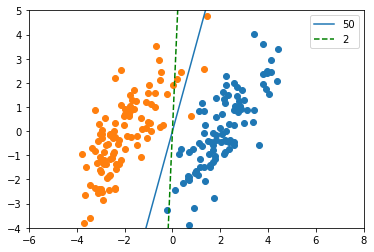

In [5]:
x = np.arange(-6.0, 8.0, 0.1)
y1 = (-w50[0, 0]*x - 0)/w50[0, 1]
y2 = (-w2[0, 0]*x - 0)/w2[0, 1]
plt.plot(x, y1, label='50')
plt.plot(x, y2, 'g--', label='2')
right_ = y == 1
plt.scatter(X[right_, 0], X[right_, 1])
plt.scatter(X[~right_, 0], X[~right_, 1])
plt.axis([-6, 8, -4, 5])
plt.legend()